In [1]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from collections import Counter
import numpy as np
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import StatePreparation


In [2]:
#backend = AerProvider().get_backend("qasm_simulator")


service  = QiskitService(str(Path.cwd() / ".env"))
backend = service.get_least_busy_backend()

Connected to IBM Quantum.


In [3]:
barrierBit = 0
data = QuantumRegister(7, 'data')
ancilla_x = QuantumRegister(3, 'ancilla_x')
ancilla_z = QuantumRegister(3, 'ancilla_z')
syndrome_x = ClassicalRegister(3, 'syndrome_x')
syndrome_z = ClassicalRegister(3, 'syndrome_z')
logical_out = ClassicalRegister(7, 'logical_out')

circuit = QuantumCircuit(ancilla_z, ancilla_x, data, syndrome_x, syndrome_z, logical_out)

# Define the amplitudes for the desired state
# Amplitudes should be normalized: sqrt(0.75) for |0⟩ and sqrt(0.25) for |1⟩
#amplitudes = [np.sqrt(0.75), np.sqrt(0.25)]

# Create the StatePreparation gate
#state_prep = StatePreparation(amplitudes)

#circuit.append(state_prep, [data[6]])



# Outcomment underneath for encoding in |1_L> (logical 1 state)
# e.g. that data[6] holds the logical bit state
circuit.h(data[6])





# Encoding for |0_L>
circuit.h(data[0])  
circuit.h(data[1])
circuit.h(data[2])
circuit.cx(data[6], data[4])
circuit.cx(data[6], data[5])
circuit.cx(data[0], data[3])
circuit.cx(data[1], data[3])
circuit.cx(data[0], data[5])
circuit.cx(data[2], data[3])
circuit.cx(data[1], data[4])
circuit.cx(data[0], data[6])
circuit.cx(data[2], data[4])
circuit.cx(data[1], data[6])
circuit.cx(data[2], data[5])

# simlating bit flip errors
circuit.z(data[6])
#circuit.x(data[3])
#circuit.x(data[6])
#circuit.x(data[1])

# simulating a  (diag(1, exp(i*phi)) phase flip error where phi = 0.1
#circuit.p(0.1, data[6])

stabilizers = [(0,1,2,3), (0,1,4,5), (0,2,4,6)]
for i, (q0, q1, q2, q3) in enumerate(stabilizers):
    circuit.barrier()
    circuit.h(ancilla_x[i])
    # Reverse the control-target order for the CNOT gates:
    circuit.cx(ancilla_x[i], data[q0])
    circuit.cx(ancilla_x[i], data[q1])
    circuit.cx(ancilla_x[i], data[q2])
    circuit.cx(ancilla_x[i], data[q3])
    circuit.h(ancilla_x[i])
    circuit.measure(ancilla_x[i], syndrome_x[i])
    circuit.barrier()
    circuit.h(ancilla_z[i])
    circuit.cz(data[q0], ancilla_z[i])
    circuit.cz(data[q1], ancilla_z[i])
    circuit.cz(data[q2], ancilla_z[i])
    circuit.cz(data[q3], ancilla_z[i])
    circuit.h(ancilla_z[i])
    circuit.measure(ancilla_z[i], syndrome_z[i])

corrections = [
    (0b111, 0),  # Qubit 0 -> Syndrome 111
    (0b011, 1),  # Qubit 1 -> Syndrome 011
    (0b101, 2),  # Qubit 2 -> Syndrome 101
    (0b001, 3),  # Qubit 3 -> Syndrome 001 
    (0b110, 4),  # Qubit 4 -> Syndrome 110
    (0b010, 5),  # Qubit 5 -> Syndrome 010
    (0b100, 6)   # Qubit 6 -> Syndrome 100
]

# Correct for phase-flip (Z) errors using the syndrome from the X stabilizers.
for pattern, qubit in corrections:
    with circuit.if_test((syndrome_x, pattern)):
        circuit.z(data[qubit])
    with circuit.if_test((syndrome_z, pattern)):
        circuit.x(data[qubit])


for i in range(7):
    circuit.measure(data[i], logical_out[i])
circuit.barrier()

#circuit.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=13, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'ancilla_z'), 0), Qubit(QuantumRegister(3, 'ancilla_z'), 1), Qubit(QuantumRegister(3, 'ancilla_z'), 2), Qubit(QuantumRegister(3, 'ancilla_x'), 0), Qubit(QuantumRegister(3, 'ancilla_x'), 1), Qubit(QuantumRegister(3, 'ancilla_x'), 2), Qubit(QuantumRegister(7, 'data'), 0), Qubit(QuantumRegister(7, 'data'), 1), Qubit(QuantumRegister(7, 'data'), 2), Qubit(QuantumRegister(7, 'data'), 3), Qubit(QuantumRegister(7, 'data'), 4), Qubit(QuantumRegister(7, 'data'), 5), Qubit(QuantumRegister(7, 'data'), 6)), clbits=())

In [4]:
# Simulation parameters
simulator = AerSimulator()  # Try default simulator first
NUM_SHOTS = 20000
classic_job = simulator.run(circuit, shots=NUM_SHOTS)
classic_result = classic_job.result()
counts = classic_result.get_counts()
CodeWord = list(counts.keys())
CodeWordNoSymptom = list({word[:7] for word in counts.keys()})
logic_1 = ['1111111', '0101010', '1001100', '0011001', '1110000', '0100101', '1000011', '0010110']
logic_0 = ["0000000", "1010101", "0110011", "1100110", "0001111", "1011010", "0111100", "1101001"]
#print(CodeWord)
#print(counts)
print(CodeWordNoSymptom)

['0001111', '0110011', '0100101', '1100110', '1101001', '1000011', '0000000', '1010101', '1011010', '1110000', '0111100', '0101010', '0011001', '0010110', '1111111', '1001100']


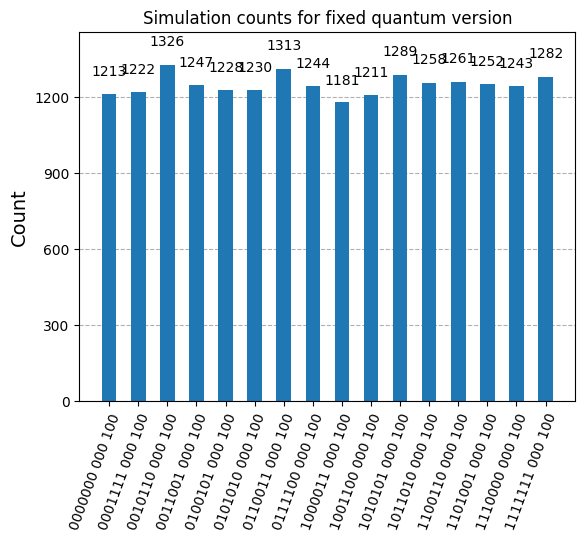

In [5]:
plot_histogram(classic_result.get_counts(), title='Simulation counts for fixed quantum version')

* Classic error correcting version down below

In [6]:
NUM_SHOTS = 3000
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend)# optimization_level=3)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots=NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: d0kn4vvfbx30008wra00, 
 Job Status: QUEUED


In [7]:
# Get results
result = job.result()
pub_result = result[0]

# Print measurement counts
print(f"Counts for 'syndrome_x' (phase flips): {pub_result.data.syndrome_x.get_counts()}")
print(f"Counts for 'syndrome_z' (bit flips): {pub_result.data.syndrome_z.get_counts()}")
print(f"Counts for 'logical_out' (data qubits): {pub_result.data.logical_out.get_counts()}")

Counts for 'syndrome_x' (phase flips): {'111': 394, '001': 397, '011': 340, '100': 336, '101': 412, '000': 381, '010': 378, '110': 362}
Counts for 'syndrome_z' (bit flips): {'000': 369, '110': 365, '100': 355, '001': 393, '101': 401, '111': 381, '011': 376, '010': 360}
Counts for 'logical_out' (data qubits): {'0001010': 18, '1011011': 6, '0000100': 38, '0011011': 20, '1110001': 22, '1000101': 31, '0011110': 21, '0111100': 26, '0110011': 27, '0010101': 29, '0110100': 30, '1101111': 15, '0101011': 18, '1100011': 16, '0110000': 36, '1000001': 32, '0111001': 34, '1010001': 29, '0110010': 17, '1000000': 25, '1100001': 34, '1101000': 26, '1100010': 22, '1000011': 15, '1110010': 20, '0100001': 46, '0100000': 46, '0010000': 30, '1001000': 19, '0111000': 28, '1011010': 15, '0001100': 24, '1001101': 18, '0111010': 15, '1111010': 18, '1101010': 10, '0101001': 50, '0100110': 25, '1111000': 26, '0111101': 23, '1000010': 14, '0000011': 31, '0101101': 27, '0000000': 60, '1000100': 30, '0011001': 38, 

In [15]:
print(counts)

{'0001010': 18, '1011011': 6, '0000100': 38, '0011011': 20, '1110001': 22, '1000101': 31, '0011110': 21, '0111100': 26, '0110011': 27, '0010101': 29, '0110100': 30, '1101111': 15, '0101011': 18, '1100011': 16, '0110000': 36, '1000001': 32, '0111001': 34, '1010001': 29, '0110010': 17, '1000000': 25, '1100001': 34, '1101000': 26, '1100010': 22, '1000011': 15, '1110010': 20, '0100001': 46, '0100000': 46, '0010000': 30, '1001000': 19, '0111000': 28, '1011010': 15, '0001100': 24, '1001101': 18, '0111010': 15, '1111010': 18, '1101010': 10, '0101001': 50, '0100110': 25, '1111000': 26, '0111101': 23, '1000010': 14, '0000011': 31, '0101101': 27, '0000000': 60, '1000100': 30, '0011001': 38, '0110111': 15, '0011111': 20, '0101100': 25, '1001100': 20, '1111001': 23, '1000111': 17, '0010100': 34, '0111111': 18, '1011001': 10, '1001011': 16, '0101110': 24, '1111111': 6, '0101000': 38, '0001110': 15, '1011000': 19, '1111110': 10, '0110101': 31, '0001001': 28, '1011110': 7, '1010000': 26, '0001101': 2

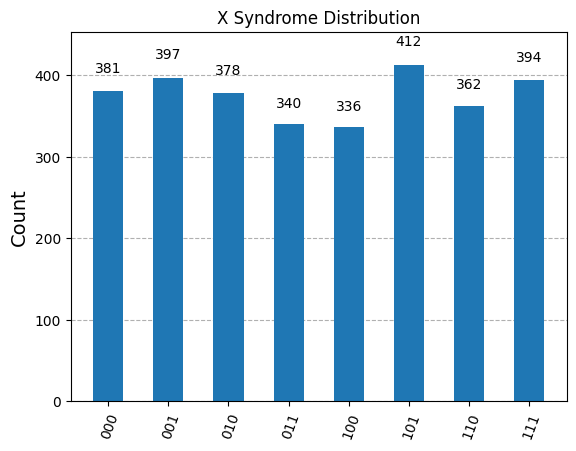

In [ ]:

# Optional: Visualize the syndrome distributions
plot_histogram(pub_result.data.syndrome_x.get_counts(), title="X Syndrome Distribution")

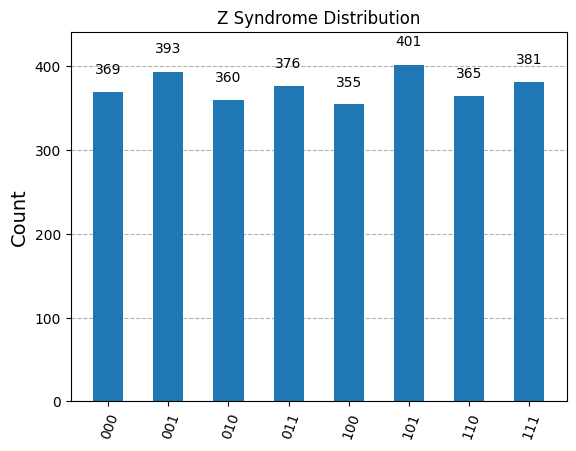

In [ ]:
plot_histogram(pub_result.data.syndrome_z.get_counts(), title="Z Syndrome Distribution")


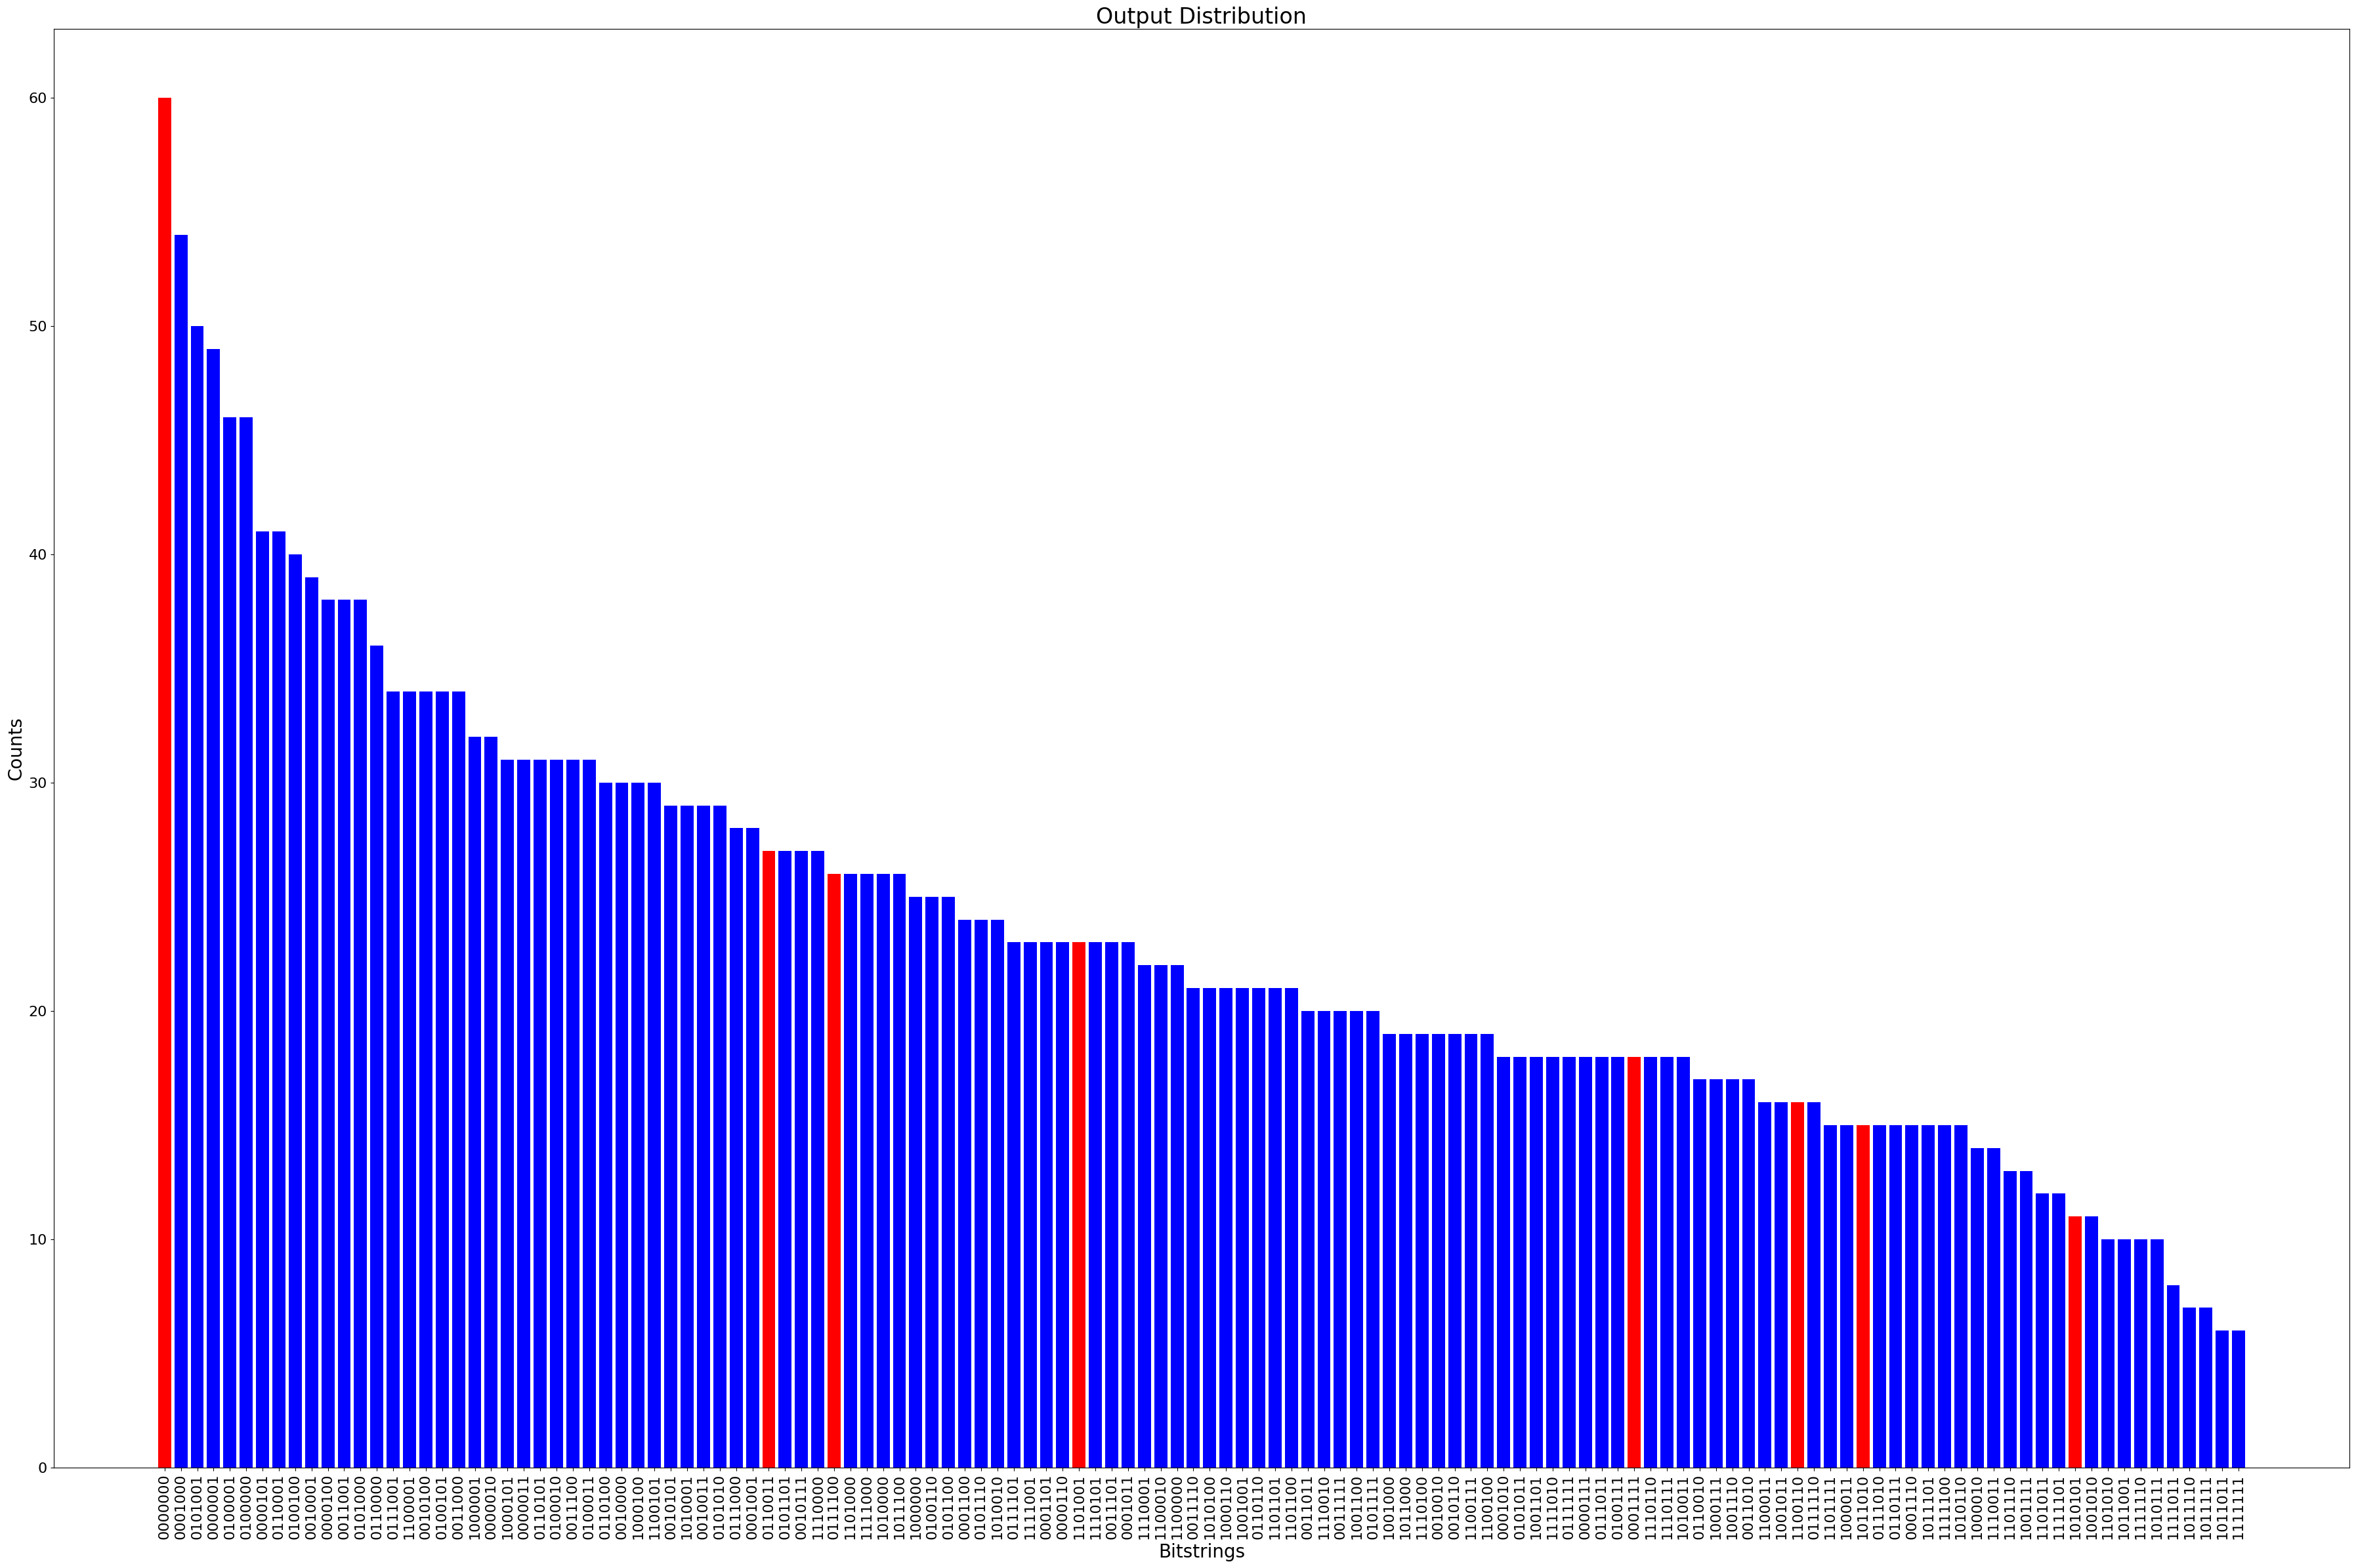

In [ ]:
import matplotlib.pyplot as plt

steane_code_logic_0 = {"0000000", "1010101", "0110011", "1100110", 
                       "0001111", "1011010", "0111100", "1101001"}

# Get the counts data
counts = pub_result.data.logical_out.get_counts()

# Sort the counts for better visualization
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
colors = [
    "red" if key in steane_code_logic_0 
    else "blue" 
    for key in keys
]
# Create the bar chart
plt.figure(figsize=(36, 24))
plt.bar(keys, values, color=colors)

# Add labels and title
plt.xlabel("Bitstrings", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.title("Output Distribution", fontsize=24)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Calculate the total counts for the desired states in steane_code_logic_0
desired_counts = sum(counts[key] for key in steane_code_logic_0 if key in counts)

# Print the result
print(f"Total counts for desired states in steane_code_logic_0: {desired_counts}")

# Calculate the percentage of desired states
percentage = (desired_counts / NUM_SHOTS) * 100
print(f"Percentage of desired states: {percentage:.2f}%")

# Calculate the number of distinct values encountered
distinct_values = len(counts)
print(f"Number of distinct values encountered: {distinct_values}")

Total counts for desired states in steane_code_logic_0: 196
Percentage of desired states: 6.53%
Number of distinct values encountered: 128


In [14]:
# Convert logical_out BitArray to a probability vector

# Get counts from logical_out
logical_out_counts = pub_result.data.logical_out.get_counts()

# Calculate total shots
total_shots = sum(logical_out_counts.values())

# Create a probability vector
probability_vector = [count / total_shots for count in logical_out_counts.values()]

# Print the probability vector in a readable format
#print("Probability vector:")
#for i, prob in enumerate(probability_vector):
#    print(f"  Outcome {i + 1}: {prob:.6f}")

# Calculate and print the Shannon entropy
entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy: {entropy_value:.6f}")


Shannon Entropy: 6.874742
